# Visualization of ours+DiCE on Adult dataset

In [1]:
%load_ext autoreload
%autoreload 2

import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split

from textualizer import Textualizer
from nn_model import NNModel
from counterfactual_generator import CounterfactualGenerator
from data import MixedEncoder

### Get data

In [2]:
data = pd.read_csv('adult_frame.csv')
data = data.replace("<50k", 0)
data = data.replace(">=50k", 1)

mapping = {'workclass': {0: 'Government', -3: 'Other/Unknown', -2: 'Private', -1: 'Self-Employed'},
     'education': {0: 'Assoc', -7: 'Bachelors', -6: 'Doctorate', -5: 'HS-grad', -4: 'Masters', -3: 'Prof-school', -2: 'School', -1: 'Some-college'},
     'marital_status': {0: 'Divorced', -4: 'Married', -3: 'Separated', -2: 'Single', -1: 'Widowed'},
     'occupation': {0: 'Blue-Collar', -5: 'Other/Unknown', -4: 'Professional', -3: 'Sales', -2: 'Service', -1: 'White-Collar'},
     'race': {0: 'Non-White', -1: 'White'},
     'gender': {0: 'Female', -1: 'Male'}}
inverted_mapping = {col: {v: k for k, v in mapping[col].items()} for col in mapping}

def map_sample(sample):
    res = []
    for val, name in zip(sample, data.columns):
        if name in mapping:
            res.append(mapping[name][val])
        else:
            res.append(val)
    return res


cat_ordering = {
    'education': [-2, -3, -5, -1, -7, -4, -6, 0]
}

# create target binary i.e. {0,1} variable to predict
target = np.asarray(data['income'], dtype=np.float32).reshape(-1, 1)
input_data = data[data.columns[0:8]]
data_train, data_test, y_train, y_test = train_test_split(input_data, target, test_size=0.2, random_state=42)

encoder = MixedEncoder(data_train, 
                       # categorical_order=cat_ordering, 
                       # increasing_columns=["age", "education"], # cannot decrease education or age
                       # causal_rels=[("education","age")], # if education goes up, age must go up as well.
                       # epsilons={"age":1},
                      )
X_train = encoder.get_encoded_data()
X_test = np.array([encoder.encode_datapoint(x) for _, x in data_test.iterrows()])

### Get NN

In [3]:
model = NNModel(X_train.shape[1], hidden_sizes=[15, 10], output_size=1)
model_path = "adult_model.pt"
to_train = False
# to_train = True
if to_train:
    model.train(X_train, y_train, batch_size=128, epochs=50)
    model.save(model_path)
else:
    model.load(model_path)

print("Train data:")
model.test(X_train, y_train)
print()
print("Test data:")
model.test(X_test, y_test)

Training:


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:16<00:00,  2.96it/s]


Train data:
Testing:
Accuracy: 83.12%
Average loss: 0.35103781310285787

Test data:
Testing:
Accuracy: 83.34%
Average loss: 0.3549962995967216


### SPN computation

In [4]:
from spn.algorithms.LearningWrappers import learn_mspn
from spn.structure.Base import Context
from spn.structure.StatisticalTypes import MetaType
from spn.algorithms.Inference import log_likelihood

import pickle

context = Context(meta_types=[
        MetaType.REAL, 
        MetaType.REAL, 
        MetaType.DISCRETE, 
        MetaType.DISCRETE, 
        MetaType.DISCRETE, 
        MetaType.DISCRETE, 
        MetaType.DISCRETE, 
        MetaType.DISCRETE, 
        MetaType.DISCRETE, 
    ])
trainset = np.concatenate([data_train, y_train], axis=1) 

context.add_domains(trainset)

spn_path = "adult_spn"
# train = True
train = False
if train:
    adult_mspn = learn_mspn(trainset, context, min_instances_slice=20)
    with open(spn_path,"wb") as f:
        pickle.dump(adult_mspn, f)
else:
    with open(spn_path,"rb") as f:
        adult_mspn = pickle.load(f)


In [5]:
def get_quantile(val, valset):
    return np.sum(val >= valset) / valset.shape[0]

trainset_lls = log_likelihood(adult_mspn, trainset)

### Get factual

In [6]:
# selected_i = 2
# test_sample = input_data.iloc[selected_i]
test_sample = pd.DataFrame([[38, 40, 'Private', 'HS-grad', 'Divorced', 'Blue-Collar', 'White', 'Male']], columns=data.columns[:-1])
test_sample = test_sample.replace(inverted_mapping)

prediction = int(model.predict(encoder.encode_datapoint(test_sample.iloc[0]))[0] >= 0)
print("FACTUAL:")
print("Prediction:", prediction)
# print("True target:", int(target[selected_i][0]))
in_data = test_sample.iloc[0].to_numpy()

test_sample

FACTUAL:
Prediction: 0


,age,hours_per_week,workclass,education,marital_status,occupation,race,gender
0,38,40,-2,-5,0,0,-1,-1


#### Get MIP counterfactuals

In [7]:
relative_distance_q = 1 # relative distance to optimum within which to search for 
cf_generator = CounterfactualGenerator(encoder)
counterfactuals = cf_generator.generate_close_counterfactuals(in_data, 
                                                              model,
                                                              relative_distance_q,
                                                              verbose=False)

Set parameter Username
Academic license - for non-commercial use only - expires 2024-11-13


In [8]:
counterfacts = np.array([cf.counter_fact * encoder.scales for cf in counterfactuals])
counter_predictions = np.array([[cf.counter_class] for cf in counterfactuals])

counter_points = np.concatenate([counterfacts, counter_predictions], axis=1)

In [9]:
cf_ll = log_likelihood(adult_mspn, counter_points)
cf_mapped = np.array([map_sample(cf) for cf in counter_points], dtype=object)
quantiles = np.array([[get_quantile(cfl, trainset_lls)] for cfl in cf_ll])
our_cfs = pd.DataFrame(np.concatenate([cf_ll, quantiles, cf_mapped], axis=1)[np.argsort(-cf_ll, axis=0).reshape(-1)], columns=["Log-likelihood", "Quantile"] + list(data.columns))
our_cfs

,Log-likelihood,Quantile,age,hours_per_week,workclass,education,marital_status,occupation,race,gender,income
0,-7.116744,0.940533,38.0,40.0,Private,Bachelors,Married,White-Collar,White,Male,1.0
1,-8.987402,0.814189,38.0,40.0,Private,Bachelors,Married,Blue-Collar,White,Male,1.0
2,-9.128171,0.800829,40.4103,40.0,Private,Bachelors,Married,Blue-Collar,White,Male,1.0
3,-10.823747,0.618397,53.253897,40.0,Private,HS-grad,Married,White-Collar,White,Male,1.0
4,-11.167255,0.579699,38.0,40.0,Private,Bachelors,Married,Blue-Collar,White,Female,1.0
5,-11.19036,0.577204,47.910724,40.0,Private,Bachelors,Married,Blue-Collar,White,Male,1.0
6,-11.37455,0.55367,38.0,40.0,Private,Masters,Married,Blue-Collar,White,Male,1.0
7,-12.265953,0.448211,44.748608,40.0,Private,HS-grad,Married,Professional,White,Male,1.0
8,-13.413395,0.327895,38.0,40.0,Private,Masters,Divorced,White-Collar,White,Male,1.0
9,-17.180639,0.067913,32.001682,41.335436,Private,Bachelors,Married,Blue-Collar,White,Male,1.0


#### Get DiCE counterfactuals

In [10]:
import dice_ml

# add sigmoid layer
from copy import deepcopy
from torch import nn
model_sigmoid = deepcopy(model)
model_sigmoid.model.append(nn.Sigmoid())
model_sigmoid.model, model.model

(Sequential(
   (0): Linear(in_features=29, out_features=15, bias=True)
   (1): ReLU()
   (2): Linear(in_features=15, out_features=10, bias=True)
   (3): ReLU()
   (4): Linear(in_features=10, out_features=1, bias=True)
   (5): Sigmoid()
 ),
 Sequential(
   (0): Linear(in_features=29, out_features=15, bias=True)
   (1): ReLU()
   (2): Linear(in_features=15, out_features=10, bias=True)
   (3): ReLU()
   (4): Linear(in_features=10, out_features=1, bias=True)
 ))

In [11]:
d = dice_ml.Data(dataframe=data, continuous_features=['age', 'hours_per_week'], outcome_name='income')

backend = 'PYT'

def my_func(sample, **kwargs):
    # print(data_interface.feature_names)
    colnames = [] 
    for s in data.columns:
        if s not in mapping:
            colnames.append(s)
        elif s != "income":
            colnames += [s+f"{i}" for i in range(len(mapping[s]))]
    result = pd.DataFrame([encoder.encode_datapoint(sample.iloc[0])], columns=colnames[:-1])
    return result

def my_inv_func(samples, **kwargs):
    results = []
    for i in range(samples.shape[0]):
        result = []
        sample = samples.iloc[i]
        for ctx in encoder.context:
            columns = [col for col in samples.columns if ctx.name in col]
            vals = sample[columns]
    
            if ctx.purely_categ:
                # all decisions are for categorical values, it is a fully categorical variable
                result.append(ctx.categ_opts[np.argmax(vals)])
            else:
                cont_val = vals[:1][0]
                one_hot = vals[1:]
                if sum(one_hot) == 0:  # return continuous
                    result.append(cont_val * ctx.scale)
                else:
                    result.append(ctx.categ_opts[np.argmax(one_hot)])
        results.append(result)
    return pd.DataFrame(results, columns=[ctx.name for ctx in encoder.context])

# the inerse transformation is a workaround, that works only because I edited the dice library. 
# the change required is on line 329 (can change) of the dice_ml/utils/helpers.py file 
# in the function initialize_transform_func(self), if using custom function, add the inverse function as well             
# self.data_transformer = FunctionTransformer(func=self.func, inverse_func=self.kw_args["inverse_func"], kw_args=self.kw_args, validate=False)
# above is the edited line, arrows point to the edit          ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
# link to github repo reference to the line https://github.com/interpretml/DiCE/blob/48832802c2a0822a9b203f3057e6def9e8ba0d0a/dice_ml/utils/helpers.py#L329C12-L329C12

kw_args = {}
kw_args["inverse_func"] = my_inv_func
backend = "PYT"
m = dice_ml.Model(model=model_sigmoid.model, backend=backend,  func=my_func, kw_args=kw_args)

# m = dice_ml.Model(model_path=ML_modelpath, backend=backend,  func="ohe-min-max")
exp = dice_ml.Dice(d, m, method="gradient")

In [12]:
# generate counterfactuals
dice_exp = exp.generate_counterfactuals(test_sample, total_CFs=10, desired_class="opposite",
                                        features_to_vary=["age", "hours_per_week", "workclass", "education", "marital_status", "occupation"],
                                        permitted_range={'age': [test_sample["age"], data["age"].max()], 
                                                        "hours_per_week": [data["hours_per_week"].min(), data["hours_per_week"].max()]
                                                        }
                                       )
dice_counterfacts = dice_exp.cf_examples_list[0].final_cfs_df
dice_counterfacts["income"] = np.round(dice_counterfacts["income"]) # from sigmoid output to class

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:20<00:00, 20.22s/it]

Diverse Counterfactuals found! total time taken: 00 min 20 sec


In [13]:
dice_cf_ll = log_likelihood(adult_mspn, dice_counterfacts.to_numpy())

dice_cf_mapped = np.array([map_sample(cf) for cf in dice_counterfacts.to_numpy()], dtype=object)
dice_quantiles = np.array([[get_quantile(cfl, trainset_lls)] for cfl in dice_cf_ll])
dice_cfs = pd.DataFrame(np.concatenate([dice_cf_ll, dice_quantiles, dice_cf_mapped], axis=1)[np.argsort(-dice_cf_ll, axis=0).reshape(-1)], columns=["Log-likelihood", "Quantile"] + list(data.columns))
dice_cfs

,Log-likelihood,Quantile,age,hours_per_week,workclass,education,marital_status,occupation,race,gender,income
0,-15.762155,0.139396,38.0,65.0,Private,Masters,Married,Blue-Collar,White,Male,1.0
1,-18.72978,0.02791,41.0,13.0,Private,Doctorate,Married,White-Collar,White,Male,1.0
2,-18.831412,0.026605,45.0,81.0,Private,Doctorate,Divorced,White-Collar,White,Male,1.0
3,-18.984113,0.024455,25.0,53.0,Self-Employed,Prof-school,Divorced,Professional,White,Male,1.0
4,-19.423505,0.019157,46.0,30.0,Private,Prof-school,Separated,Professional,White,Male,1.0
5,-20.092994,0.013398,36.0,37.0,Private,Doctorate,Widowed,White-Collar,White,Male,1.0
6,-20.741153,0.009406,76.0,26.0,Government,Doctorate,Divorced,Sales,White,Male,1.0
7,-22.136712,0.005989,29.0,42.0,Government,Doctorate,Married,Sales,White,Male,1.0
8,-46.614803,0.001612,90.0,40.0,Self-Employed,Prof-school,Married,Blue-Collar,White,Male,1.0
9,-49.727139,0.000115,90.0,46.0,Private,Masters,Divorced,Professional,White,Male,1.0


#### Get VAE counterfactuals

In [14]:
import dice_ml_04.dice_ml as dice_ml_04 # downgraded version, heavily edited
d04 = dice_ml_04.Data(dataframe=data, continuous_features=['age', 'hours_per_week'], outcome_name='income', encoder=encoder)

backend = {'model': 'pytorch_model.PyTorchModel',
           'explainer': 'feasible_base_vae.FeasibleBaseVAE'}
m04 = dice_ml_04.Model(model=model.model, backend=backend, encoder=encoder)
exp04 = dice_ml_04.Dice(d04, m04, encoded_size=10, lr=1e-2,
                   batch_size=2048, validity_reg=42.0, margin=0.165, epochs=25,
                   wm1=1e-2, wm2=1e-2, wm3=1e-2)
exp04.train()

2023-12-15 16:13:09.813212: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-12-15 16:13:09.813292: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-12-15 16:13:09.817857: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-12-15 16:13:09.833279: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-12-15 16:13:10.818512: W tensorflow/compiler/tf2

feasible_base_vae FeasibleBaseVAE
Dataset Shape: (32561, 30)
Datasets Columns: Index(['age', 'hours_per_week', 'workclass_-3', 'workclass_-2', 'workclass_-1',
       'workclass_0', 'education_-7', 'education_-6', 'education_-5',
       'education_-4', 'education_-3', 'education_-2', 'education_-1',
       'education_0', 'marital_status_-4', 'marital_status_-3',
       'marital_status_-2', 'marital_status_-1', 'marital_status_0',
       'occupation_-5', 'occupation_-4', 'occupation_-3', 'occupation_-2',
       'occupation_-1', 'occupation_0', 'race_-1', 'race_0', 'gender_-1',
       'gender_0', 'income'],
      dtype='object')


/home/epanemu/Work/Counterfactuals/counterfactual_explanations/dice_ml_04/dice_ml/utils/sample_architecture/vae_model.py:105: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  c=torch.tensor(c).float()


recon:  tensor(44.2271, grad_fn=<NegBackward0>)  KL:  tensor(0.0898, grad_fn=<MeanBackward0>)  Validity:  tensor([48.5582], grad_fn=<NegBackward0>)
recon:  tensor(40.3186, grad_fn=<NegBackward0>)  KL:  tensor(0.0934, grad_fn=<MeanBackward0>)  Validity:  tensor([48.5220], grad_fn=<NegBackward0>)
recon:  tensor(37.6840, grad_fn=<NegBackward0>)  KL:  tensor(0.0975, grad_fn=<MeanBackward0>)  Validity:  tensor([48.4207], grad_fn=<NegBackward0>)
recon:  tensor(36.8263, grad_fn=<NegBackward0>)  KL:  tensor(0.1030, grad_fn=<MeanBackward0>)  Validity:  tensor([48.1888], grad_fn=<NegBackward0>)
recon:  tensor(35.2073, grad_fn=<NegBackward0>)  KL:  tensor(0.1121, grad_fn=<MeanBackward0>)  Validity:  tensor([47.7014], grad_fn=<NegBackward0>)
recon:  tensor(34.3536, grad_fn=<NegBackward0>)  KL:  tensor(0.1292, grad_fn=<MeanBackward0>)  Validity:  tensor([46.7437], grad_fn=<NegBackward0>)
recon:  tensor(32.7529, grad_fn=<NegBackward0>)  KL:  tensor(0.1507, grad_fn=<MeanBackward0>)  Validity:  tensor

In [15]:
vaedice_exp = exp04.generate_counterfactuals(test_sample, total_CFs=10, desired_class="opposite", encoder=encoder)

vaedice_counterfacts = vaedice_exp.final_cfs_df
vaedice_cf_ll = log_likelihood(adult_mspn, vaedice_counterfacts.to_numpy())

vaedice_cf_mapped = np.array([map_sample(cf) for cf in vaedice_counterfacts.to_numpy()], dtype=object)
vaedice_quantiles = np.array([[get_quantile(cfl, trainset_lls)] for cfl in vaedice_cf_ll])
vaedice_cfs = pd.DataFrame(np.concatenate([vaedice_cf_ll, vaedice_quantiles, vaedice_cf_mapped], axis=1)[np.argsort(-vaedice_cf_ll, axis=0).reshape(-1)], columns=["Log-likelihood", "Quantile"] + list(data.columns))

tensor([[0.4203, 0.4093, 1.0000, 0.0000, 0.0000, 0.0000, 1.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 1.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 1.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 1.0000, 0.0000,
         0.0000, 1.0000]])
ohe corrected x has a wrong prediction: tensor([[0.4391]], grad_fn=<AddmmBackward0>)
tensor([[0.4188, 0.4055, 1.0000, 0.0000, 0.0000, 0.0000, 1.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 1.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 1.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 1.0000, 0.0000,
         0.0000, 1.0000]])
ohe corrected x has a wrong prediction: tensor([[0.4235]], grad_fn=<AddmmBackward0>)
tensor([[0.4409, 0.4057, 1.0000, 0.0000, 0.0000, 0.0000, 1.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 1.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 1.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 1.0000, 0.0000,
         0.0000, 1.0000]])
ohe corrected x has 

/home/epanemu/Work/Counterfactuals/counterfactual_explanations/dice_ml_04/dice_ml/explainer_interfaces/feasible_base_vae.py:191: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_y = (self.pred_model(torch.tensor(train_x[0]).float()) > 0.5).float()
/home/epanemu/Work/Counterfactuals/counterfactual_explanations/dice_ml_04/dice_ml/utils/sample_architecture/vae_model.py:123: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  c=torch.tensor(c).float()
/home/epanemu/Work/Counterfactuals/counterfactual_explanations/dice_ml_04/dice_ml/utils/sample_architecture/vae_model.py:136: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clon

tensor([[0.4164, 0.4125, 1.0000, 0.0000, 0.0000, 0.0000, 1.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 1.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 1.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 1.0000, 0.0000,
         0.0000, 1.0000]])
ohe corrected x has a wrong prediction: tensor([[0.4397]], grad_fn=<AddmmBackward0>)
tensor([[0.4030, 0.4053, 1.0000, 0.0000, 0.0000, 0.0000, 1.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 1.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 1.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 1.0000, 0.0000,
         0.0000, 1.0000]])
ohe corrected x has a wrong prediction: tensor([[0.3854]], grad_fn=<AddmmBackward0>)
tensor([[0.4303, 0.4056, 1.0000, 0.0000, 0.0000, 0.0000, 1.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 1.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 1.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 1.0000, 0.0000,
         0.0000, 1.0000]])
ohe corrected x has 

,Log-likelihood,Quantile,age,hours_per_week,workclass,education,marital_status,occupation,race,gender,income
0,-14.5766,0.222781,46.0,40.0,Other/Unknown,Bachelors,Married,Other/Unknown,White,Female,1.0
1,-14.5766,0.222781,46.0,40.0,Other/Unknown,Bachelors,Married,Other/Unknown,White,Female,1.0
2,-14.578902,0.222666,43.0,40.0,Other/Unknown,Bachelors,Married,Other/Unknown,White,Female,1.0
3,-14.578902,0.222666,43.0,40.0,Other/Unknown,Bachelors,Married,Other/Unknown,White,Female,1.0
4,-14.608874,0.218827,42.0,40.0,Other/Unknown,Bachelors,Married,Other/Unknown,White,Female,1.0
5,-14.664207,0.21445,44.0,40.0,Other/Unknown,Bachelors,Married,Other/Unknown,White,Female,1.0
6,-14.664207,0.21445,44.0,40.0,Other/Unknown,Bachelors,Married,Other/Unknown,White,Female,1.0
7,-14.67916,0.213145,45.0,40.0,Other/Unknown,Bachelors,Married,Other/Unknown,White,Female,1.0
8,-16.494057,0.100161,43.0,43.0,Other/Unknown,Bachelors,Married,Other/Unknown,White,Female,1.0
9,-17.10276,0.071023,39.0,44.0,Other/Unknown,Bachelors,Married,Other/Unknown,White,Female,1.0


In [20]:
vaedice_cfs

,Log-likelihood,Quantile,age,hours_per_week,workclass,education,marital_status,occupation,race,gender,income
0,-14.5766,0.222781,46.0,40.0,Other/Unknown,Bachelors,Married,Other/Unknown,White,Female,1.0
1,-14.5766,0.222781,46.0,40.0,Other/Unknown,Bachelors,Married,Other/Unknown,White,Female,1.0
2,-14.578902,0.222666,43.0,40.0,Other/Unknown,Bachelors,Married,Other/Unknown,White,Female,1.0
3,-14.578902,0.222666,43.0,40.0,Other/Unknown,Bachelors,Married,Other/Unknown,White,Female,1.0
4,-14.608874,0.218827,42.0,40.0,Other/Unknown,Bachelors,Married,Other/Unknown,White,Female,1.0
5,-14.664207,0.21445,44.0,40.0,Other/Unknown,Bachelors,Married,Other/Unknown,White,Female,1.0
6,-14.664207,0.21445,44.0,40.0,Other/Unknown,Bachelors,Married,Other/Unknown,White,Female,1.0
7,-14.67916,0.213145,45.0,40.0,Other/Unknown,Bachelors,Married,Other/Unknown,White,Female,1.0
8,-16.494057,0.100161,43.0,43.0,Other/Unknown,Bachelors,Married,Other/Unknown,White,Female,1.0
9,-17.10276,0.071023,39.0,44.0,Other/Unknown,Bachelors,Married,Other/Unknown,White,Female,1.0


### Visualize

In [16]:
n_sample = 100
att1 = "age"
att2 = "hours_per_week"
limits = { # values on the borders have too low likelihoods
    "age": [17, 85],
    "hours_per_week": [5, 90],
}
labels = {
    "age":"age",
    "hours_per_week":"hours/week",
}
# att1 must be before att2!!!!!!
if np.argmax(data.columns == att1) > np.argmax(data.columns == att2):
    att1, att2 = att2, att1
x1, x2 = np.meshgrid(np.linspace(limits[att1][0], limits[att1][1], n_sample), np.linspace(limits[att2][0], limits[att2][1], n_sample))
spn_indices = [i for i in range(len(data.columns)) if data.columns[i] in [att1, att2]]


samples = np.concatenate([np.zeros((n_sample**2, spn_indices[0])), 
                          x1.reshape(-1,1), 
                          np.zeros((n_sample**2, spn_indices[1]-spn_indices[0]-1)), 
                          x2.reshape(-1,1), 
                         ], axis=1)

# samples = np.concatenate([np.zeros((n_sample**2, spn_indices[0])), 
#                           x1.reshape(-1,1), 
#                           np.zeros((n_sample**2, spn_indices[1]-spn_indices[0]-1)), 
#                           x2.reshape(-1,1), 
#                           np.zeros((n_sample**2, len(data.columns)-3)), 
#                           np.ones((n_sample**2, 1)) # add true class 
#                          ], axis=1)

# samples = np.concatenate([np.zeros((n_sample**2, spn_indices[0])), 
#                           x1.reshape(-1,1), 
#                           np.zeros((n_sample**2, spn_indices[1]-spn_indices[0]-1)), 
#                           x2.reshape(-1,1), 
#                           np.zeros((n_sample**2, len(data.columns)-5)), 
#                           -np.ones((n_sample**2, 2)), # add immutable attributes 
#                           np.ones((n_sample**2, 1)) # add true class 
#                          ], axis=1)

In [17]:
from spn.algorithms.Marginalization import marginalize

# outcome_index = len(data.columns)-1
# immutable = ["race", "sex"]
# immutable_indices = [i for i in range(len(data.columns)) if data.columns[i] in immutable]
# adult_mspn_marg = marginalize(adult_mspn, spn_indices+immutable_indices+[outcome_index])

adult_mspn_marg = marginalize(adult_mspn, spn_indices)

ll_samples = log_likelihood(adult_mspn_marg, samples)

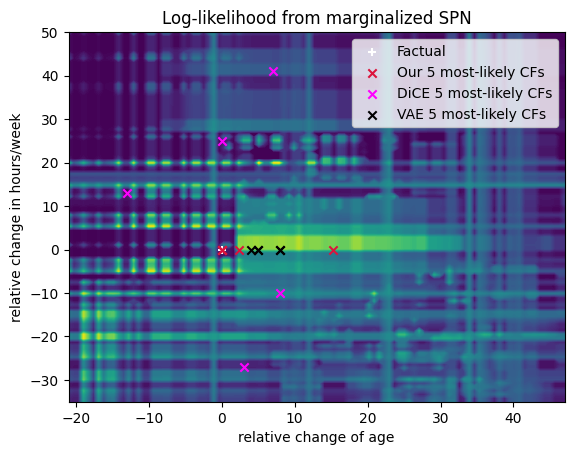

In [21]:
from matplotlib import pyplot as plt

fact1 = test_sample[att1].iloc[0] # value in dimension 1 
fact2 = test_sample[att2].iloc[0] # val in dim 2
plt.contourf(x1-fact1, x2-fact2, ll_samples.reshape(n_sample, n_sample), 100)

plt.scatter([0], [0], marker="+", color="white", label="Factual")
plt.scatter(our_cfs[att1][:5]-fact1, our_cfs[att2][:5]-fact2, marker="x", color="crimson", label="Our 5 most-likely CFs")
plt.scatter(dice_cfs[att1][:5]-fact1, dice_cfs[att2][:5]-fact2, marker="x", color="magenta", label="DiCE 5 most-likely CFs")
plt.scatter(vaedice_cfs[att1][:5]-fact1, vaedice_cfs[att2][:5]-fact2, marker="x", color="black", label="VAE 5 most-likely CFs")

plt.legend()
plt.xlabel(f"relative change of {labels[att1]}")
plt.ylabel(f"relative change in {labels[att2]}")
plt.title("Log-likelihood from marginalized SPN")
plt.show()